In [1]:
%matplotlib inline
from __future__ import print_function
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def conv_block(inputs, out_channels, name='conv'):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(inputs, out_channels, kernel_size=4, strides=2, padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
        conv = tf.nn.relu(conv)
        #conv = tf.contrib.layers.max_pool2d(conv, 2)
        return conv

In [3]:
def encoder(x, h_dim, z_dim, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        net = conv_block(x, h_dim, name='conv_1')
        net = conv_block(net, h_dim, name='conv_2')
        net = conv_block(net, h_dim, name='conv_3')
        net = conv_block(net, z_dim, name='conv_4')
        net = tf.contrib.layers.flatten(net)
        return net

In [4]:
def deconv_block(inputs, out_channels, name='deconv'):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d_transpose(inputs, out_channels, kernel_size=4, strides=2, padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
        conv = tf.nn.relu(conv)
        return conv

In [5]:
def decoder(x, h_dim, z_dim, reuse=False):
    with tf.variable_scope('decoder', reuse=reuse):
        net = tf.layers.dense(x, 3 * 3 * 64)
        net = tf.layers.dense(net, 7 * 7 * 64)
        net = tf.reshape(net, [-1, 7, 7, 64])
        net = deconv_block(net, h_dim, name='deconv_1')
        print(net.shape)
        net = deconv_block(net, h_dim, name='deconv_2')
        print(net.shape)
        #net = deconv_block(net, z_dim, name='deconv_3')
        net = tf.layers.conv2d(net, 1, 3, padding='SAME')
        print(net.shape)
        net = tf.nn.tanh(net)
        return net

In [6]:
def euclidean_distance(a, b):
    # a.shape = N x D
    # b.shape = M x D
    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [7]:
def save_imgs(fig, axs, images, name, ep):
    for j in range(25):
        axs[j//5, j%5].imshow(images[j*12, :, :, 0], cmap='gray')
        axs[j//5, j%5].axis('off')
    fig.savefig("images/omniglot_{}_{}.png".format(ep, name))

In [8]:
n_epochs = 20
n_episodes = 100
n_way = 60
n_shot = 5
n_query = 5
n_examples = 20
im_width, im_height, channels = 28, 28, 1
h_dim = 64
z_dim = 64

In [9]:
# Load Train Dataset
root_dir = './data/omniglot'
train_split_path = os.path.join(root_dir, 'splits', 'train.txt')
with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]
n_classes = len(train_classes)
train_dataset = np.zeros([n_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(train_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(root_dir, 'data', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        train_dataset[i, j] = im
print(train_dataset.shape)

(4112, 20, 28, 28)


In [10]:
x = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
q = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
x_shape = tf.shape(x)
q_shape = tf.shape(q)
num_classes, num_support = x_shape[0], x_shape[1]
num_queries = q_shape[1]
y = tf.placeholder(tf.int64, [None, None])
y_one_hot = tf.one_hot(y, depth=num_classes)
emb_x = encoder(tf.reshape(x, [num_classes * num_support, im_height, im_width, channels]), h_dim, z_dim)
emb_dim = tf.shape(emb_x)[-1]
emb_x = tf.reduce_mean(tf.reshape(emb_x, [num_classes, num_support, emb_dim]), axis=1)

_input = tf.reshape(q, [num_classes * num_queries, im_height, im_width, channels])
emb_q = encoder(_input, h_dim, z_dim, reuse=True)

q_hat = decoder(emb_q, h_dim, z_dim)
q_label = tf.reshape(q, [num_classes * num_queries, im_height, im_width, channels])
recon_loss = tf.reduce_mean(tf.square(q_label-q_hat))

dists = euclidean_distance(emb_q, emb_x)
log_p_y = tf.reshape(tf.nn.log_softmax(-dists), [num_classes, num_queries, -1])
ce_loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, log_p_y), axis=-1), [-1]))
acc = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(log_p_y, axis=-1), y)))

(?, 14, 14, 64)
(?, 28, 28, 64)
(?, 28, 28, 1)


In [11]:
train_op = tf.train.AdamOptimizer().minimize(recon_loss)

In [12]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)

[epoch 1/20, episode 50/100] => loss: 3.79703, acc: 0.18333
[epoch 1/20, episode 100/100] => loss: 3.80937, acc: 0.33333
[epoch 2/20, episode 50/100] => loss: 3.91796, acc: 0.47000
[epoch 2/20, episode 100/100] => loss: 3.95754, acc: 0.52333
[epoch 3/20, episode 50/100] => loss: 3.99104, acc: 0.47667
[epoch 3/20, episode 100/100] => loss: 4.01606, acc: 0.45667
[epoch 4/20, episode 50/100] => loss: 4.03949, acc: 0.41333
[epoch 4/20, episode 100/100] => loss: 4.04199, acc: 0.37333
[epoch 5/20, episode 50/100] => loss: 4.05350, acc: 0.44333
[epoch 5/20, episode 100/100] => loss: 4.05529, acc: 0.40000
[epoch 6/20, episode 50/100] => loss: 4.06362, acc: 0.44000
[epoch 6/20, episode 100/100] => loss: 4.06443, acc: 0.34000
[epoch 7/20, episode 50/100] => loss: 4.06567, acc: 0.38667
[epoch 7/20, episode 100/100] => loss: 4.06699, acc: 0.40333
[epoch 8/20, episode 50/100] => loss: 4.06550, acc: 0.38333
[epoch 8/20, episode 100/100] => loss: 4.07020, acc: 0.37000
[epoch 9/20, episode 50/100] => 

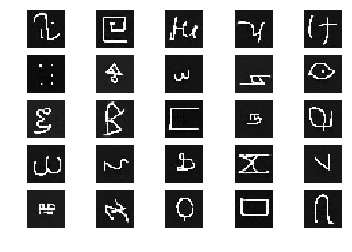

In [13]:
fig, axs = plt.subplots(5, 5)
for ep in range(n_epochs):
    for epi in range(n_episodes):
        epi_classes = np.random.permutation(n_classes)[:n_way]
        support = np.zeros([n_way, n_shot, im_height, im_width], dtype=np.float32)
        query = np.zeros([n_way, n_query, im_height, im_width], dtype=np.float32)
        for i, epi_cls in enumerate(epi_classes):
            selected = np.random.permutation(n_examples)[:n_shot + n_query]
            support[i] = train_dataset[epi_cls, selected[:n_shot]]
            query[i] = train_dataset[epi_cls, selected[n_shot:]]
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_query)).astype(np.uint8)
        _, ls, ac, origin_images, images = sess.run([train_op, ce_loss, acc, _input, q_hat], feed_dict={x: support, q: query, y:labels})
        if (epi+1) % 50 == 0:
            print('[epoch {}/{}, episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(ep+1, n_epochs, epi+1, n_episodes, ls, ac))
            save_imgs(fig, axs, origin_images, "origin", ep)
            save_imgs(fig, axs, images, "generated", ep)

In [14]:
# Load Test Dataset
root_dir = './data/omniglot'
test_split_path = os.path.join(root_dir, 'splits', 'test.txt')
with open(test_split_path, 'r') as test_split:
    test_classes = [line.rstrip() for line in test_split.readlines()]
n_test_classes = len(test_classes)
test_dataset = np.zeros([n_test_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(test_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(root_dir, 'data', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        test_dataset[i, j] = im
print(test_dataset.shape)

(1692, 20, 28, 28)


In [30]:
n_test_episodes = 1000
n_test_way = 20
n_test_shot = 5
n_test_query = 15

In [31]:
print('Testing...')
avg_acc = 0.
for epi in range(n_test_episodes):
    epi_classes = np.random.permutation(n_test_classes)[:n_test_way]
    support = np.zeros([n_test_way, n_test_shot, im_height, im_width], dtype=np.float32)
    query = np.zeros([n_test_way, n_test_query, im_height, im_width], dtype=np.float32)
    for i, epi_cls in enumerate(epi_classes):
        selected = np.random.permutation(n_examples)[:n_test_shot + n_test_query]
        support[i] = test_dataset[epi_cls, selected[:n_test_shot]]
        query[i] = test_dataset[epi_cls, selected[n_test_shot:]]
    support = np.expand_dims(support, axis=-1)
    query = np.expand_dims(query, axis=-1)
    labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
    ls, ac = sess.run([ce_loss, acc], feed_dict={x: support, q: query, y:labels})
    avg_acc += ac
    if (epi+1) % 50 == 0:
        print('[test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_test_episodes, ls, ac))
avg_acc /= n_test_episodes
print('Average Test Accuracy: {:.5f}'.format(avg_acc))

Testing...
[test episode 50/1000] => loss: 2.98150, acc: 0.40000
[test episode 100/1000] => loss: 2.98053, acc: 0.40000
[test episode 150/1000] => loss: 2.98333, acc: 0.25000
[test episode 200/1000] => loss: 2.98051, acc: 0.60000
[test episode 250/1000] => loss: 2.97690, acc: 0.50000
[test episode 300/1000] => loss: 2.98466, acc: 0.25000
[test episode 350/1000] => loss: 2.97789, acc: 0.45000
[test episode 400/1000] => loss: 2.97774, acc: 0.40000
[test episode 450/1000] => loss: 2.97988, acc: 0.35000
[test episode 500/1000] => loss: 2.97437, acc: 0.40000
[test episode 550/1000] => loss: 2.97558, acc: 0.60000
[test episode 600/1000] => loss: 2.97358, acc: 0.40000
[test episode 650/1000] => loss: 2.98350, acc: 0.25000
[test episode 700/1000] => loss: 2.97646, acc: 0.55000
[test episode 750/1000] => loss: 2.97488, acc: 0.75000
[test episode 800/1000] => loss: 2.97892, acc: 0.35000
[test episode 850/1000] => loss: 2.98168, acc: 0.40000
[test episode 900/1000] => loss: 2.97886, acc: 0.45000
